In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import astropy.units as u
import numpy as np
import tracemalloc
import time
import matplotlib.pyplot as plt
from scipy import special
import os.path

In [2]:
def guillot_pt(Teq, T_int,grav, logg1, logKir, alpha,nlevel, p_bottom, p_top):
    kv1, kv2 =10.**(logg1+logKir),10.**(logg1+logKir)
    kth=10.**logKir

    Teff = T_int
    f = 1.0  # solar re-radiation factor
    A = 0.0  # planetary albedo
    g0 = grav #cm/s2 to m/s2

    # Compute equilibrium temperature and set up gamma's
    T0 = Teq
    gamma1 = kv1/kth #Eqn. 25
    gamma2 = kv2/kth

    # Initialize arrays
    logtau =np.arange(-10,20,.1)
    tau =10**logtau

    #computing temperature
    T4ir = 0.75*(Teff**(4.))*(tau+(2.0/3.0))
    f1 = 2.0/3.0 + 2.0/(3.0*gamma1)*(1.+(gamma1*tau/2.0-1.0)*np.exp(-gamma1*tau))+2.0*gamma1/3.0*(1.0-tau**2.0/2.0)*special.expn(2.0,gamma1*tau)
    f2 = 2.0/3.0 + 2.0/(3.0*gamma2)*(1.+(gamma2*tau/2.0-1.0)*np.exp(-gamma2*tau))+2.0*gamma2/3.0*(1.0-tau**2.0/2.0)*special.expn(2.0,gamma2*tau)

    T4v1=f*0.75*T0**4.0*(1.0-alpha)*f1
    T4v2=f*0.75*T0**4.0*alpha*f2
    T=(T4ir+T4v1+T4v2)**(0.25)
    P=tau*g0/(kth*0.1)/1.E5

    logP = np.linspace(p_top,p_bottom,nlevel)
    newP = 10.0**logP
    T = np.interp(logP,np.log10(P),T)
    
    return T   

In [55]:
def run_planet(T_int,grav,a,T_star,logg,metal,rstar,mh,CtoO,rfacv):
    mh = mh
    CtoO = CtoO

    filename_db="/Users/sagnickmukherjee/Documents/GitHub/picaso-dev/reference/opacities/ck_cx_cont_opacities.db"
    ck_db='/Users/sagnickmukherjee/Documents/software/picaso-dev/reference/opacities/ck_db/m'+mh+'_co'+CtoO+'.data.196'

    
    path = "/Users/sagnickmukherjee/Documents/research/geers/wasp96b"
    file_path= path+"/tpfile/tp_eq_planet_"+str(int(T_int))+"_grav_8.25_mh_"+mh+"_CO_"+CtoO+"_sm_0.0453_v_0.5_.dat"
    pressure,temp_guess = np.loadtxt(file_path,usecols=[0,1],unpack=True)
    file_temp = open(file_path)
    header = file_temp.readline()
    
    if int(header[18]) == 0:
        nstr1 = int(header[11]+header[12])+12
    else:
        nstr1 = 83
    pressure =np.logspace(np.log10(1e-6),np.log10(100),91)
    opacity_ck = jdi.opannection(ck=True, ck_db=ck_db,filename_db=filename_db)#, deq = True, first_deq = True)


    # planet prop
    semi_major = a #0.0355 #"NA" # AU
    T_eff = T_int
    grav = grav
    r_planet = 1 # needed for vulcan photochem runs

    ### star prop
    T_star = T_star
    logg = logg
    metal = metal
    r_star = rstar




    nlevel = 91
    #pressure=np.logspace(np.log10(1e-6),np.log10(200.0),nlevel)
    #temp_guess = np.zeros(shape=(nlevel)) 
    kz = np.zeros(shape =(nlevel))
    #pressure_dummy,temp_guess,t1,t2,t3,t4 = np.loadtxt("/data/users/samukher/Disequilibrium-picaso/structures_m+0.0/t"+str(round(600/100.0)*100)+"g"+str(31)+"nc_m0.0.dat",usecols=[1,2,3,4,5,6],unpack=True, skiprows = 1)
    #Teq = T_star*np.sqrt(rstar/(2*semi_major*216))
    #temp_guess = guillot_pt(Teq=Teq, T_int=T_int,grav=grav, logg1=-1, logKir=-1.5, alpha=0.5,nlevel=91, p_bottom = np.log10(np.max(pressure)), p_top =np.log10(np.min(pressure)))

    #pdummy,temp_guess = np.loadtxt(path+"tpfile/tp_eq_planet_200_grav_4.5_mh_+0.0_CO_0.5_sm_0.0486_v_0.5_.dat",usecols=[0,1],unpack=True)
    
    nofczns = 1
    #nstr1 = 85
    nstr = np.array([0,nstr1,89,0,0,0])
    rfacv = rfacv
    rfaci =1.0
    cloudy = False
    fsed = 2




    ###### run start

    cl_run = jdi.inputs(calculation="planet", climate = True)

    cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

    cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)'))
    cl_run.T_eff(Teff=T_eff)





    cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, nstr = nstr, nofczns = nofczns , rfacv = rfacv, rfaci = rfaci, cloudy = cloudy, mh = mh, CtoO = CtoO,species = ['MgSiO3','Mg2SiO4','Fe'], fsed = fsed, T_star = T_star, logg = logg, metal = metal, r_star = r_star, semi_major = semi_major)

    #tracemalloc.start()
    t0 = time.time()
    pressure , temp, dtdp, nstr_new, flux_plus_final, df, all_profiles,opd_cld,g0_cld,w0_cld = cl_run.run_climate_model(opacity_ck,save_all_profiles=True,diseq_chem = False, self_consistent_kzz =False, kz = kz )
    t1 = time.time()
    print(t1-t0)
   
    quench_levels=np.array([0,0,0,0])
    path = "/Users/sagnickmukherjee/Documents/research/geers/wasp96b/"

    filename= path+"tpfile_new/tp_eq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    np.savetxt(filename, np.transpose([pressure,temp]), header= str("nstr "+str(nstr_new)+" T_eff "+str(T_eff)+" grav "+ str(grav)+" kz "+str(kz[0])+" T_star "+str(T_star)+" semi-major[AU] "+str(semi_major)))        

    csv = path+"profile_new/profile_eq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    df.to_csv(csv,sep='\t')

    hist = path+"hist_new/hist_eq_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_.dat"
    np.savetxt(hist, all_profiles)
    
    return t1-t0

In [56]:
'''
#T_int = np.array([100,200,300])
T_int=np.array([300])
grav = np.array([4.5])
T_star,logg,metal,rstar = 5326.6,4.38933,-0.03,0.939
mh = np.array(['+1.5'])
CtoO =np.array(['0.5','1.0','1.5','2.0'])
#mh=np.array(['+2.5'])
#CtoO =np.array(['1.0'])
a,e = 0.0486, 0
cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.4,0.5])

for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        t= run_planet(T_int[i],grav[j],semi_major_ar[m],T_star,logg,metal,rstar,mh[k],CtoO[l],rfacv[o])
'''    


"\n#T_int = np.array([100,200,300])\nT_int=np.array([300])\ngrav = np.array([4.5])\nT_star,logg,metal,rstar = 5326.6,4.38933,-0.03,0.939\nmh = np.array(['+1.5'])\nCtoO =np.array(['0.5','1.0','1.5','2.0'])\n#mh=np.array(['+2.5'])\n#CtoO =np.array(['1.0'])\na,e = 0.0486, 0\ncosv = np.array([0])\n#semi_major_ar = a*(1-e**2)/(1+e*cosv)\nsemi_major_ar = np.array([a])\nrfacv = np.array([0.4,0.5])\n\nfor i in range(len(T_int)):\n    for j in range(len(grav)):\n        for k in range(len(mh)):\n            for l in range(len(CtoO)):\n                for m in range(len(semi_major_ar)):\n                    for o in range(len(rfacv)):\n                        t= run_planet(T_int[i],grav[j],semi_major_ar[m],T_star,logg,metal,rstar,mh[k],CtoO[l],rfacv[o])\n"

In [58]:
#T_int = np.array([100,200,300])
T_int=np.array([300])
grav = np.array([8.25])
T_star,logg,metal,rstar = 5560.000,4.42,0.14,1.098
#mh = np.array(['-1.0','-0.5','+0.0','+0.5','+1.0','+1.7','+1.5','+2.0'])
mh = np.array(['+1.0'])

CtoO =np.array(['1.0'])
a,e = 0.0453, 0

cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.5])

for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        t= run_planet(T_int[i],grav[j],semi_major_ar[m],T_star,logg,metal,rstar,mh[k],CtoO[l],rfacv[o])


Iteration number  0 , min , max temp  853.4550835049545 4700.859097873517 , flux balance  74.65234540737076
Iteration number  1 , min , max temp  865.5713666304047 4637.9187442718385 , flux balance  5.759175491589534
Iteration number  2 , min , max temp  865.2951393620353 4626.732662407056 , flux balance  0.05148783482909439
Iteration number  3 , min , max temp  865.2946195089761 4626.0474657347795 , flux balance  1.7279220202568482e-05
Iteration number  4 , min , max temp  865.2946192789717 4626.039885712147 , flux balance  3.7237333520115293e-09
Converged Solution in iterations  4
Big iteration is  865.2946192789717 0
Iteration number  0 , min , max temp  865.8747247533663 4459.250097498644 , flux balance  13.901778890189112
Iteration number  1 , min , max temp  866.5057422039702 4259.518045331898 , flux balance  0.3143842429947193
Iteration number  2 , min , max temp  866.5023946966879 4243.084519844825 , flux balance  0.00023755714188598056
Iteration number  3 , min , max temp  866

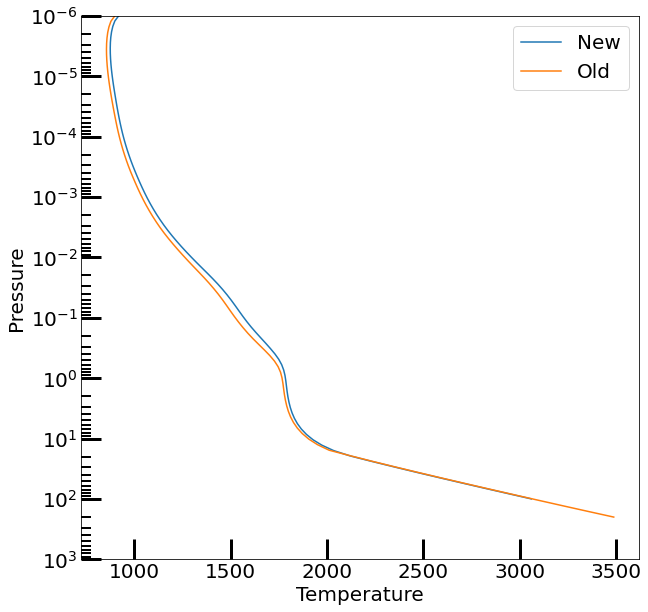

In [24]:
import pandas as pd
path = "/Users/sagnickmukherjee/Documents/research/geers/wasp96b/profile/"
df1 = pd.read_csv(path+"newRst_profile_eq_planet_200_grav_8.25_mh_+1.5_CO_1.0_sm_0.0453_v_0.5_.dat",delimiter="\t")

df2 = pd.read_csv(path+"profile_eq_planet_200_grav_8.25_mh_+1.5_CO_1.0_sm_0.0453_v_0.5_.dat",delimiter="\t")

plt.figure(figsize=(10,10))
plt.ylim(1e3,1e-6)
#plt.xlim(800,1500)
plt.xlabel("Temperature",fontsize=20)
plt.ylabel("Pressure",fontsize=20)
plt.semilogy(df1['temperature'],df1['pressure'],label="New")
plt.semilogy(df2['temperature'],df2['pressure'],label="Old")
plt.legend(fontsize=20)
plt.tick_params(axis='both',which='major',length =20, width=3,direction='in',labelsize=20)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=20)


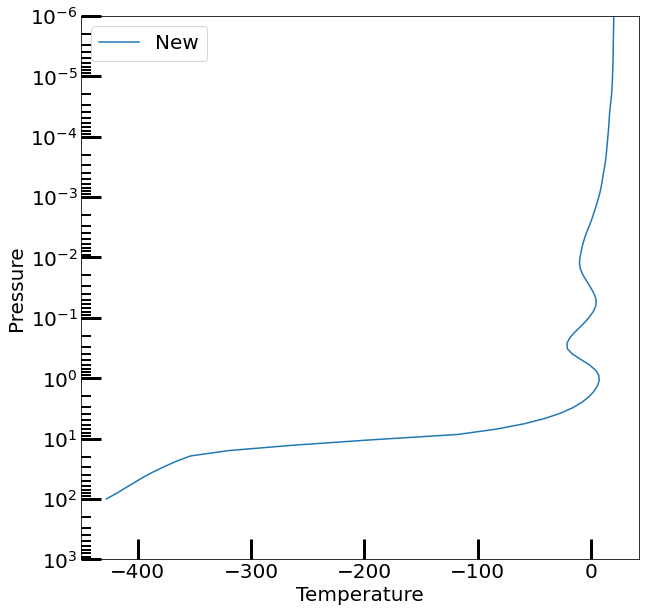

In [21]:
plt.figure(figsize=(10,10))
plt.ylim(1e3,1e-6)
plt.xlabel("Temperature",fontsize=20)
plt.ylabel("Pressure",fontsize=20)
plt.semilogy(df1['temperature']-df2['temperature'],df1['pressure'],label="New")
#plt.semilogy(df2['temperature'],df2['pressure'],label="Old")
plt.legend(fontsize=20)
plt.tick_params(axis='both',which='major',length =20, width=3,direction='in',labelsize=20)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=20)


In [14]:
path = "/Users/sagnickmukherjee/Documents/research/geers/wasp96b/tpfile/"
p,t = np.loadtxt(path+"tp_eq_planet_200_grav_8.25_mh_+1.5_CO_1.0_sm_0.0453_v_0.5_.dat",usecols=[0,1],unpack=True)
f = open(path+"tp_eq_planet_200_grav_8.25_mh_+1.5_CO_1.0_sm_0.0453_v_0.5_.dat")
header = f.readline()
print(header)
#df2 = pd.read_csv(path+"profile_eq_planet_200_grav_8.25_mh_+1.5_CO_1.0_sm_0.0453_v_0.5_.dat",delimiter="\t")


# nstr [ 0 78 89  0  0  0] T_eff 200 grav 8.25 kz 0.0 T_star 5560.0 semi-major[AU] 0.0453



In [19]:
print(header[9],header[11]+header[12],header[14]+header[15],header[18])

0 78 89 0
